In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
from scipy.signal import resample
import matplotlib.pyplot as plt

import seaborn as sns


In [22]:


def load_biosignal_dataset(parent_directory):
    """
    Load biosignal data from a structured dataset directory.

    Parameters:
        parent_directory (str): Path to the parent directory containing biosignal data.

    Returns:
        dict: A dictionary containing aggregated data with the structure:
            {
                'pain_level': {
                    'subject': {
                        'signals': Dictionary of biosignal arrays,
                        'labels': List of labels,
                        'sampling_rate': Sampling rate
                    }
                }
            }
    """
    aggregated_data = {}  # To store data for all pain levels and subjects

    # Iterate through pain level folders
    for pain_level in os.listdir(parent_directory):
        pain_level_path = os.path.join(parent_directory, pain_level)
        
        # Check if the pain level path is a directory
        if not os.path.isdir(pain_level_path):
            continue  # Skip non-directory items
        
        aggregated_data[pain_level] = {}  # Initialize data for this pain level

        # Iterate through subject folders
        for subject in os.listdir(pain_level_path):
            subject_path = os.path.join(pain_level_path, subject)
            
            # Check if the subject path is a directory
            if not os.path.isdir(subject_path):
                continue  # Skip non-directory items
            
            aggregated_data[pain_level][subject] = {}  # Initialize data for this subject

            # Look for .mat files in the subject folder
            mat_files = [f for f in os.listdir(subject_path) if f.endswith('.mat')]

            # Handle missing files
            if not mat_files:
                print(f"Warning: No .mat files found in {subject_path}")
                continue  # Skip this subject if no .mat files are present

            # Process each .mat file
            for mat_file in mat_files:
                mat_file_path = os.path.join(subject_path, mat_file)
                
                try:
                    # Load the .mat file
                    data = loadmat(mat_file_path)
                    
                    # Extract biosignal data and metadata
                    signals = data['data']  # Replace 'data' with the actual key for biosignal matrix
                    labels = [label[0] for label in data['labels']]  # Replace 'labels' with the actual key
                    sampling_rate = data['fs'][0, 0]  # Replace 'fs' with the actual key
                    
                    # Add data to the dictionary
                    aggregated_data[pain_level][subject] = {
                        'signals': signals,
                        'labels': labels,
                        'sampling_rate': sampling_rate
                    }
                except Exception as e:
                    print(f"Error loading {mat_file_path}: {e}")
                    continue  # Skip this file if there's an error

    return aggregated_data

# Example Usage
parent_directory = "D:\\bio_s"
dataset = load_biosignal_dataset(parent_directory)

# Display structure
for pain_level, subjects in dataset.items():
    print(f"Pain Level: {pain_level}")
    for subject, data in subjects.items():
        print(f"  Subject: {subject}")
        print(f"    Signals Shape: {data['signals'].shape}")
        print(f"    Labels: {data['labels']}")
        print(f"    Sampling Rate: {data['sampling_rate']}")

Pain Level: baseline
  Subject: S008
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000.0405967653777
  Subject: S009
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000.0405923707193
  Subject: S012
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000.038922778678
  Subject: S019
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000.0402649842337
  Subject: S026
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000.0405659607077
  Subject: S034
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000.0396144699149
  Subject: S036
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000.0408044772456
  Subject: S045
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000.0415391298654
  Su

In [23]:


def load_biosignal_dataset(parent_directory, target_sampling_rate=1000, target_signal_length=30000):
    """
    Load biosignal data from a structured dataset directory and normalize sampling rates and signal lengths.

    Parameters:
        parent_directory (str): Path to the parent directory containing biosignal data.
        target_sampling_rate (int): Target sampling rate (Hz) for all signals.
        target_signal_length (int): Target length (number of samples) for all signals.

    Returns:
        dict: A dictionary containing aggregated data with the structure:
            {
                'pain_level': {
                    'subject': {
                        'signals': Dictionary of biosignal arrays (normalized),
                        'labels': List of labels,
                        'sampling_rate': Sampling rate
                    }
                }
            }
    """
    aggregated_data = {}  # To store data for all pain levels and subjects

    # Iterate through pain level folders
    for pain_level in os.listdir(parent_directory):
        pain_level_path = os.path.join(parent_directory, pain_level)
        
        if not os.path.isdir(pain_level_path):  # Skip non-directory items
            continue
        
        aggregated_data[pain_level] = {}  # Initialize data for this pain level

        # Iterate through subject folders
        for subject in os.listdir(pain_level_path):
            subject_path = os.path.join(pain_level_path, subject)
            
            if not os.path.isdir(subject_path):  # Skip non-directory items
                continue
            
            aggregated_data[pain_level][subject] = {}  # Initialize data for this subject

            # Look for .mat files in the subject folder
            mat_files = [f for f in os.listdir(subject_path) if f.endswith('.mat')]

            if not mat_files:
                print(f"Warning: No .mat files found in {subject_path}")
                continue  # Skip this subject if no .mat files are present

            # Process each .mat file
            for mat_file in mat_files:
                mat_file_path = os.path.join(subject_path, mat_file)
                
                try:
                    # Load the .mat file
                    data = loadmat(mat_file_path)
                    
                    # Extract biosignal data and metadata
                    signals = data['data']  # Replace 'data' with the actual key for biosignal matrix
                    labels = [label[0] for label in data['labels']]  # Replace 'labels' with the key
                    sampling_rate = data['fs'][0, 0]  # Replace 'fs' with the actual key
                    
                    # Normalize sampling rate
                    if abs(sampling_rate - target_sampling_rate) > 1e-2:  # Check if resampling is needed
                        num_samples = int(target_signal_length * target_sampling_rate / sampling_rate)
                        signals = resample(signals, num_samples, axis=0)
                    
                    # Handle variable signal lengths
                    num_samples = signals.shape[0]
                    if num_samples < target_signal_length:
                        # Pad signals to reach the target length
                        padding = target_signal_length - num_samples
                        signals = np.pad(signals, ((0, padding), (0, 0)), mode='constant')
                    elif num_samples > target_signal_length:
                        # Truncate signals to the target length
                        signals = signals[:target_signal_length, :]
                    
                    # Add data to the dictionary
                    aggregated_data[pain_level][subject] = {
                        'signals': signals,
                        'labels': labels,
                        'sampling_rate': target_sampling_rate
                    }
                except Exception as e:
                    print(f"Error loading {mat_file_path}: {e}")
                    continue  # Skip this file if there's an error

    return aggregated_data

# Example Usage
parent_directory = "D:\\bio_s"
dataset = load_biosignal_dataset(parent_directory)

# Display structure
for pain_level, subjects in dataset.items():
    print(f"Pain Level: {pain_level}")
    for subject, data in subjects.items():
        print(f"  Subject: {subject}")
        print(f"    Signals Shape: {data['signals'].shape}")
        print(f"    Labels: {data['labels']}")
        print(f"    Sampling Rate: {data['sampling_rate']}")

Pain Level: baseline
  Subject: S008
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000
  Subject: S009
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000
  Subject: S012
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000
  Subject: S019
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000
  Subject: S026
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000
  Subject: S034
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000
  Subject: S036
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000
  Subject: S045
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000
  Subject: S049
    Signals Shape: (30000, 5)
    Labels: ['C', 'Z', 'T', 'S', 'E']
    Sampling Rate: 1000
  Subje

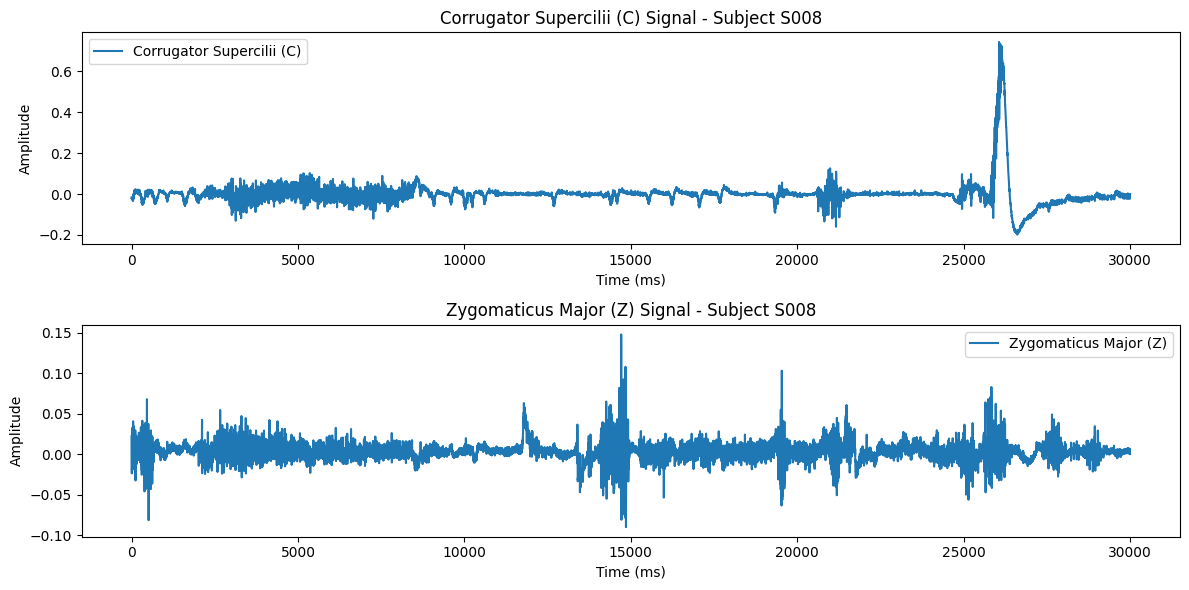

Statistics for Subject S008:
  Corrugator Supercilii (C): {'mean': np.float64(-0.000969895866563585), 'variance': np.float64(0.0038686937926024536), 'range': (np.float64(-0.1983525904426166), np.float64(0.7433788071710817))}
  Zygomaticus Major (Z): {'mean': np.float64(0.0028445572577582468), 'variance': np.float64(0.00010255367284632064), 'range': (np.float64(-0.09017598269694742), np.float64(0.14781797751419795))}


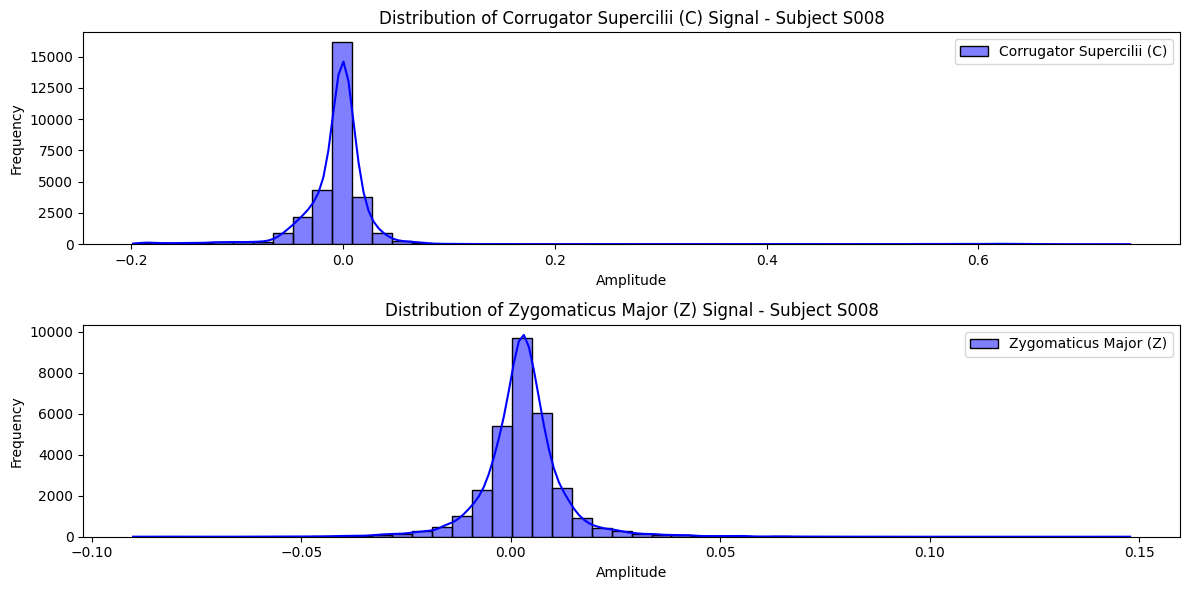

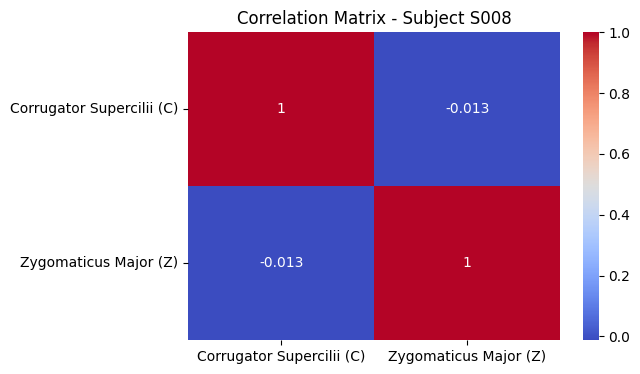

In [24]:
def plot_emg_signals(subject_data, labels, subject_id):
    """
    Plot EMG signals for Corrugator supercilii ('C') and Zygomaticus major ('Z').

    Parameters:
        subject_data (np.ndarray): Biosignal data for the subject (shape: [time, channels]).
        labels (list): Names of the biosignal channels.
        subject_id (str): ID of the subject for labeling the plot.
    """
    # Extract only EMG signals: 'C' and 'Z'
    emg_indices = [labels.index('C'), labels.index('Z')]
    emg_data = subject_data[:, emg_indices]
    emg_labels = ['Corrugator Supercilii (C)', 'Zygomaticus Major (Z)']
    
    time = np.arange(emg_data.shape[0])  # Time axis (samples)
    
    plt.figure(figsize=(12, 6))
    for i, label in enumerate(emg_labels):
        plt.subplot(len(emg_labels), 1, i + 1)
        plt.plot(time, emg_data[:, i], label=label)
        plt.title(f"{label} Signal - Subject {subject_id}")
        plt.xlabel("Time (ms)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.tight_layout()
    plt.show()

def compute_emg_statistics(subject_data, labels):
    """
    Compute statistics for EMG signals ('C' and 'Z') of a single subject.

    Parameters:
        subject_data (np.ndarray): Biosignal data for the subject (shape: [time, channels]).
        labels (list): Names of the biosignal channels.

    Returns:
        dict: Statistics (mean, variance, range) for 'C' and 'Z'.
    """
    emg_indices = [labels.index('C'), labels.index('Z')]
    emg_data = subject_data[:, emg_indices]
    emg_labels = ['Corrugator Supercilii (C)', 'Zygomaticus Major (Z)']
    
    statistics = {}
    for i, label in enumerate(emg_labels):
        channel_data = emg_data[:, i]
        statistics[label] = {
            "mean": np.mean(channel_data),
            "variance": np.var(channel_data),
            "range": (np.min(channel_data), np.max(channel_data))
        }
    return statistics

def plot_emg_distributions(subject_data, labels, subject_id):
    """
    Plot distributions (histograms) for EMG signals ('C' and 'Z') of a single subject.

    Parameters:
        subject_data (np.ndarray): Biosignal data for the subject (shape: [time, channels]).
        labels (list): Names of the biosignal channels.
        subject_id (str): ID of the subject for labeling the plot.
    """
    emg_indices = [labels.index('C'), labels.index('Z')]
    emg_data = subject_data[:, emg_indices]
    emg_labels = ['Corrugator Supercilii (C)', 'Zygomaticus Major (Z)']
    
    plt.figure(figsize=(12, 6))
    for i, label in enumerate(emg_labels):
        plt.subplot(len(emg_labels), 1, i + 1)
        sns.histplot(emg_data[:, i], kde=True, bins=50, label=label, color='blue')
        plt.title(f"Distribution of {label} Signal - Subject {subject_id}")
        plt.xlabel("Amplitude")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
    plt.show()

def analyze_emg_correlation(subject_data, labels, subject_id):
    """
    Compute and visualize correlation matrix for EMG signals ('C' and 'Z') of a single subject.

    Parameters:
        subject_data (np.ndarray): Biosignal data for the subject (shape: [time, channels]).
        labels (list): Names of the biosignal channels.
        subject_id (str): ID of the subject for labeling the plot.
    """
    emg_indices = [labels.index('C'), labels.index('Z')]
    emg_data = subject_data[:, emg_indices]
    emg_labels = ['Corrugator Supercilii (C)', 'Zygomaticus Major (Z)']
    
    correlation_matrix = np.corrcoef(emg_data.T)  # Compute correlation matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_matrix, xticklabels=emg_labels, yticklabels=emg_labels, annot=True, cmap="coolwarm")
    plt.title(f"Correlation Matrix - Subject {subject_id}")
    plt.show()

# Example Usage
# Assuming we have loaded dataset as a dictionary (pain_level -> subject -> data)
pain_level = "baseline"
subject_id = "S008"
subject_data = dataset[pain_level][subject_id]['signals']
labels = dataset[pain_level][subject_id]['labels']

# Plot EMG signals
plot_emg_signals(subject_data, labels, subject_id)

# Compute EMG statistics
stats = compute_emg_statistics(subject_data, labels)
print(f"Statistics for Subject {subject_id}:")
for label, stat in stats.items():
    print(f"  {label}: {stat}")

# Plot EMG distributions
plot_emg_distributions(subject_data, labels, subject_id)

# Analyze EMG correlation
analyze_emg_correlation(subject_data, labels, subject_id)

In [36]:
from scipy.signal import butter, filtfilt
import numpy as np

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a bandpass filter to the data.

    Parameters:
        data (np.ndarray): Input signal data.
        lowcut (float): Lower cutoff frequency for the bandpass filter (Hz).
        highcut (float): Higher cutoff frequency for the bandpass filter (Hz).
        fs (int): Sampling rate of the signal (Hz).
        order (int): Order of the filter.

    Returns:
        np.ndarray: Filtered signal data.
    """
    nyquist = 0.5 * fs  # Nyquist frequency

    # Validate cutoff frequencies
    if lowcut >= nyquist or highcut >= nyquist:
        raise ValueError(f"Cutoff frequencies must be less than the Nyquist frequency ({nyquist} Hz).")
    if lowcut <= 0 or highcut <= 0:
        raise ValueError("Cutoff frequencies must be greater than 0.")
    if lowcut >= highcut:
        raise ValueError("Lower cutoff frequency must be less than the higher cutoff frequency.")

    # Adjust highcut frequency if it equals Nyquist
    if highcut == nyquist:
        highcut = nyquist - 1e-3  # Slightly reduce highcut to avoid violation

    # Normalize frequencies
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design the filter
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

def normalize_signal(data):
    """
    Normalize the signal to have zero mean and unit variance.

    Parameters:
        data (np.ndarray): Input signal data.

    Returns:
        np.ndarray: Normalized signal data.
    """
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    return normalized_data

def preprocess_emg_signals(subject_data, labels, fs=1000, lowcut=20, highcut=500):
    """
    Preprocess EMG signals (bandpass filter and normalization).

    Parameters:
        subject_data (np.ndarray): Biosignal data for the subject (shape: [time, channels]).
        labels (list): Names of the biosignal channels.
        fs (int): Sampling rate of the signal (Hz).
        lowcut (float): Lower cutoff frequency for the bandpass filter (Hz).
        highcut (float): Higher cutoff frequency for the bandpass filter (Hz).

    Returns:
        np.ndarray: Preprocessed EMG data (filtered and normalized).
        list: Labels for the preprocessed channels.
    """
    # Extract EMG signals: 'C' and 'Z'
    emg_indices = [labels.index('C'), labels.index('Z')]
    emg_data = subject_data[:, emg_indices]
    
    # Apply bandpass filter
    filtered_data = bandpass_filter(emg_data, lowcut, highcut, fs)
    
    # Normalize signals
    normalized_data = normalize_signal(filtered_data)
    
    return normalized_data, ['Corrugator Supercilii (C)', 'Zygomaticus Major (Z)']

# Example Usage
pain_level = "baseline"
subject_id = "S008"
subject_data = dataset[pain_level][subject_id]['signals']
labels = dataset[pain_level][subject_id]['labels']

# Preprocess EMG signals
preprocessed_emg_data, emg_labels = preprocess_emg_signals(subject_data, labels)

# Print results
print(f"Preprocessed EMG Signals for Subject {subject_id}:")
print(f"  Shape: {preprocessed_emg_data.shape}")
print(f"  Labels: {emg_labels}")

ValueError: Cutoff frequencies must be less than the Nyquist frequency (500.0 Hz).